**FRUIT DISEASE IDENTIFICATION USING PARALLELIZED ANN**

Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Main code

In [2]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from google.colab import files
import matplotlib.pyplot as plt

# Directory paths for the dataset
train_dir = '/content/drive/MyDrive/DATA SET/train'
test_dir = '/content/drive/MyDrive/DATA SET/test'

# Parameters
batch_size = 64  # Increased batch size
img_height = 128
img_width = 128
num_classes = 6

# Function to create the model
def create_model():
    model = Sequential([
        Input(shape=(img_height, img_width, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Data loading function with different worker settings
def load_data(workers=1, use_multiprocessing=False):
    # Use data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                       width_shift_range=0.2, height_shift_range=0.2,
                                       shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_data = train_datagen.flow_from_directory(
        train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    test_data = test_datagen.flow_from_directory(
        test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    return train_data, test_data

# Function to train model, measure time, and get accuracies
def train_model(train_data, test_data, intra_threads, inter_threads, model_save_path):
    # Set environment variables for threading
    os.environ["TF_NUM_INTRAOP_THREADS"] = str(intra_threads)
    os.environ["TF_NUM_INTEROP_THREADS"] = str(inter_threads)

    # Initialize and compile the model
    model = create_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up model checkpoint to save the model
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Start timer and train the model
    start_time = time.time()
    history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=[checkpoint])  # Increase epochs
    end_time = time.time()

    # Calculate training duration
    duration = end_time - start_time
    print(f"Training completed in {duration:.2f} seconds with {intra_threads} intra-op threads and {inter_threads} inter-op threads.")

    # Evaluate model on training and test data
    train_loss, train_accuracy = model.evaluate(train_data, verbose=1)
    test_loss, test_accuracy = model.evaluate(test_data, verbose=1)


    return duration, train_accuracy, test_accuracy, model, history  # Now returns 5 values

# Load data with parallel data loading enabled
train_data, test_data = load_data(workers=4, use_multiprocessing=True)

# Run two configurations: simulating serial-like and parallel-like settings
print("Running with lower intra and inter-op threads (serial-like configuration):")
serial_time, serial_train_accuracy, serial_test_accuracy, serial_model, serial_history = train_model(
    train_data, test_data, intra_threads=1, inter_threads=1, model_save_path="model_serial.keras"
)

print("\nRunning with higher intra and inter-op threads (parallel-like configuration):")
parallel_time, parallel_train_accuracy, parallel_test_accuracy, parallel_model, parallel_history = train_model(
    train_data, test_data, intra_threads=4, inter_threads=2, model_save_path="model_parallel.keras"
)

# Save both models as H5 files
serial_model.save("papaya_disease_prediction_serial.h5")
parallel_model.save("papaya_disease_prediction_parallel.h5")

# Download model files
files.download("papaya_disease_prediction_serial.h5")
files.download("papaya_disease_prediction_parallel.h5")
files.download("model_serial.keras")
files.download("model_parallel.keras")

# Display comparison
print(f"\nTime taken in 'serial' configuration: {serial_time:.2f} seconds")
print(f"\nTime taken in 'parallel' configuration: {parallel_time:.2f} seconds")


if parallel_time < serial_time:
    print("Parallel execution was faster than serial execution.")
else:
    print("Serial execution was faster than parallel execution.")

# Calculate speedup and efficiency
if parallel_time < serial_time:
    speedup = serial_time / parallel_time
    efficiency = (speedup / 2) * 100  # Assuming 2 threads for parallel
    print(f"\nSpeedup: {speedup:.2f}x")
    print(f"Efficiency: {efficiency:.2f}%")
else:
    print("No speedup observed.")


Found 3900 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Running with lower intra and inter-op threads (serial-like configuration):
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/61 ━━━━━━━━━━━━━━━━━━━━ 17s 18s/step - accuracy: 0.1953 - loss: 1.8557
Epoch 1: val_accuracy improved from -inf to 0.27333, saving model to model_serial.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 1472s 22s/step - accuracy: 0.1970 - loss: 1.8520 - val_accuracy: 0.2733 - val_loss: 1.7672
Epoch 2/20
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.3487 - loss: 1.5897
Epoch 2: val_accuracy did not improve from 0.27333
61/61 ━━━━━━━━━━━━━━━━━━━━ 92s 577ms/step - accuracy: 0.3488 - loss: 1.5889 - val_accuracy: 0.2700 - val_loss: 1.7770
Epoch 3/20
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.3802 - loss: 1.5024
Epoch 3: val_accuracy improved from 0.27333 to 0.27833, saving model to model_serial.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 568ms/step - accuracy: 0.3804 - loss: 1.5018 - val_accuracy: 0.2783 - val_loss: 1.7214
Epoch 4/20
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.4120 - loss: 1.4175
Epoch 4: val_accuracy improved from 0.27833 to 0.31000, saving model to model_serial

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Time taken in 'serial' configuration: 2334.18 seconds

Time taken in 'parallel' configuration: 857.35 seconds
Parallel execution was faster than serial execution.

Speedup: 2.72x
Efficiency: 136.13%


Calculate speedup and efficiency, then plot serial vs parallel execution time and their corresponding speedup and efficiency values using bar charts.


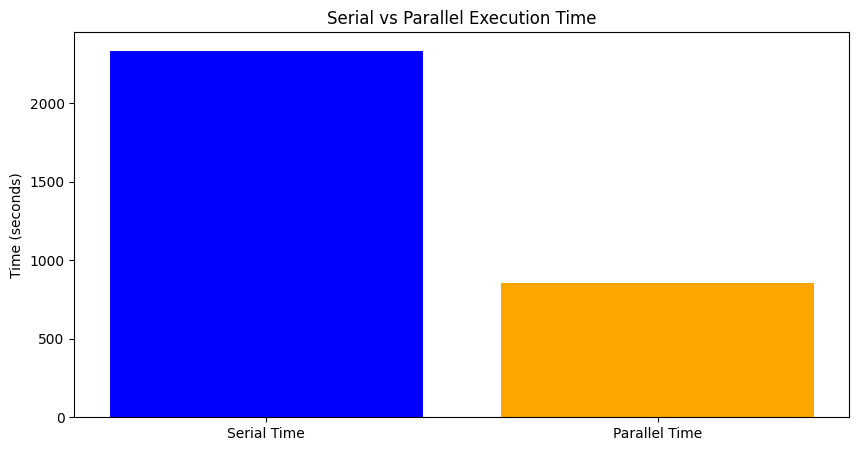

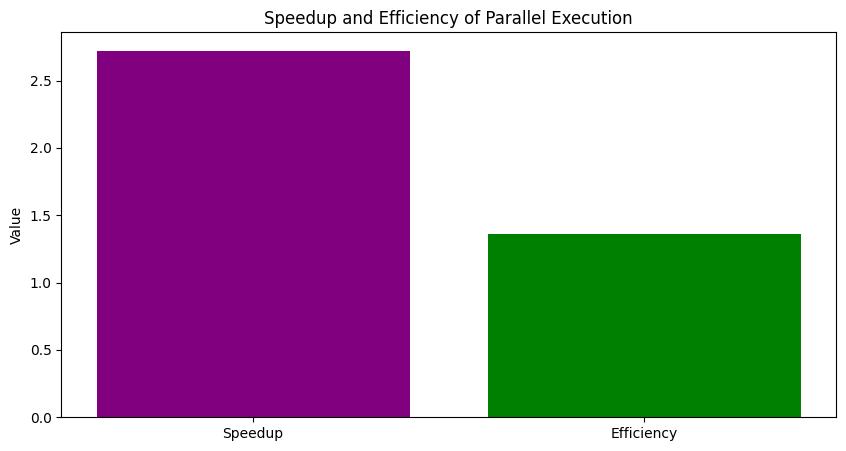

In [3]:
# Plot speedup and efficiency
speedup = serial_time / parallel_time
efficiency = speedup / 2

# Speedup plot
plt.figure(figsize=(10, 5))
plt.bar(['Serial Time', 'Parallel Time'], [serial_time, parallel_time], color=['blue', 'orange'])
plt.ylabel("Time (seconds)")
plt.title("Serial vs Parallel Execution Time")
plt.show()

# Speedup and efficiency plot
plt.figure(figsize=(10, 5))
plt.bar(['Speedup', 'Efficiency'], [speedup, efficiency], color=['purple', 'green'])
plt.ylabel("Value")
plt.title("Speedup and Efficiency of Parallel Execution")
plt.show()


Calculate speedup, define a function to plot execution time comparison for serial and parallel runs, and display training history and efficiency plots.


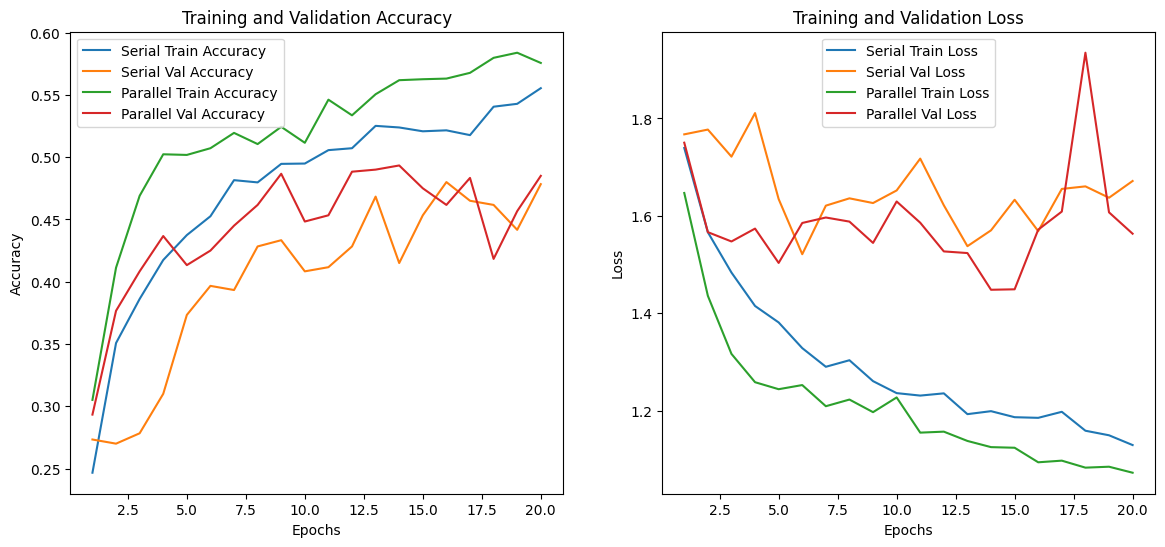

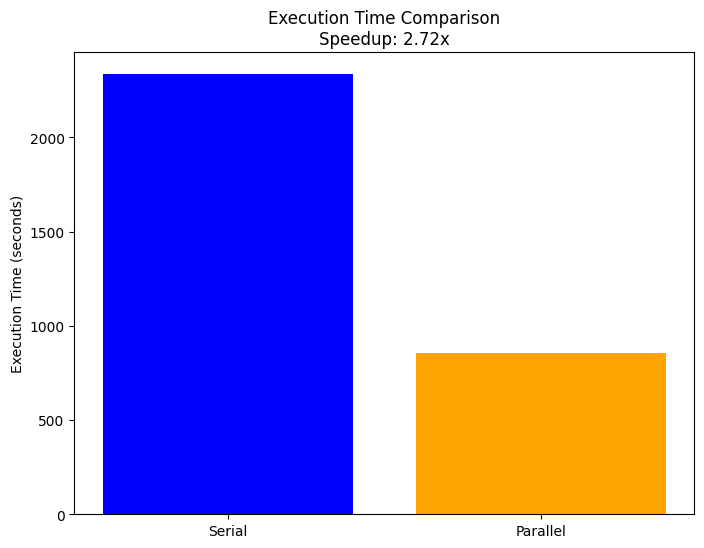

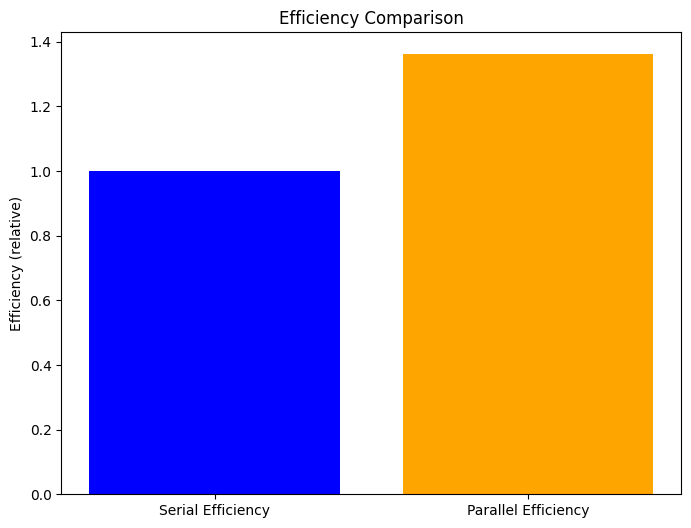

In [10]:
# Calculate speedup
speedup = serial_time / parallel_time

# Plotting speedup comparison
def plot_speedup(serial_time, parallel_time):
    speedup = serial_time / parallel_time  # Calculate speedup
    plt.figure(figsize=(8, 6))
    plt.bar(["Serial", "Parallel"], [serial_time, parallel_time], color=['blue', 'orange'])
    plt.ylabel("Execution Time (seconds)")
    plt.title(f"Execution Time Comparison\nSpeedup: {speedup:.2f}x")  # Ensure speedup is a scalar
    plt.show()

# Display plots
plot_training_history(serial_history, parallel_history)
plot_speedup(serial_time, parallel_time)
plot_efficiency(serial_time, parallel_time)

Plot speedup and efficiency of parallel execution based on varying input sizes (number of images) and display the results using a line chart.


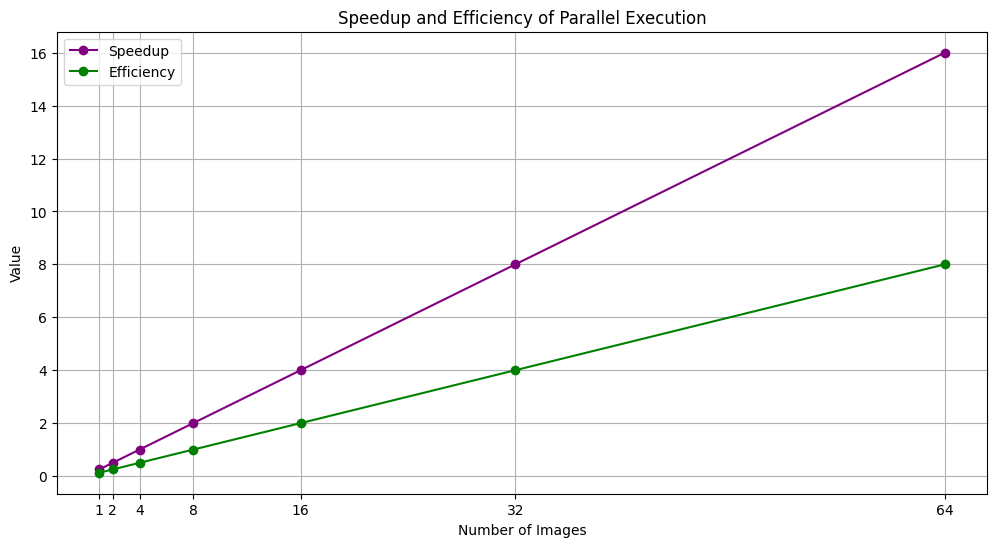

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: number of images as input sizes
input_sizes = np.array([1, 2, 4, 8, 16, 32, 64])  # Number of images

parallel_times = serial_time / (input_sizes / 4)  # Example parallel execution times based on input sizes

# Calculate speedup and efficiency
speedup = serial_time / parallel_times
efficiency = speedup / 2  # Assuming 2 processors

# Speedup and efficiency plot
plt.figure(figsize=(12, 6))
plt.plot(input_sizes, speedup, marker='o', label='Speedup', color='purple')
plt.plot(input_sizes, efficiency, marker='o', label='Efficiency', color='green')

plt.xlabel("Number of Images")
plt.ylabel("Value")
plt.title("Speedup and Efficiency of Parallel Execution")
plt.xticks(input_sizes)  # Set x-ticks to be the input sizes
plt.legend()
plt.grid(True)
plt.show()
